# Regressão Logística com PyTorch – Student Exam (via KaggleHub)

Aplicação de Regressão Logística (Softmax) ao dataset de desempenho em provas,
baixando os dados diretamente do KaggleHub (`mrsimple07/student-exam-performance-prediction`).


In [1]:
!pip install kagglehub

import os

import torch
from torch import nn, optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import kagglehub  # conforme solicitado

torch.manual_seed(1234)
np.random.seed(1234)

print("Versão do PyTorch:", torch.__version__)


Versão do PyTorch: 2.8.0+cu126


In [2]:

# Dataset: mrsimple07/student-exam-performance-prediction

path = kagglehub.dataset_download("mrsimple07/student-exam-performance-prediction")
print("Path to dataset files:", path)

csv_files = [f for f in os.listdir(path) if f.lower().endswith(".csv")]
if len(csv_files) == 0:
    raise FileNotFoundError("Nenhum arquivo .csv encontrado na pasta do dataset: " + path)

csv_path = os.path.join(path, csv_files[0])
print("Usando arquivo CSV:", csv_path)

# Carregando o dataset
df = pd.read_csv(csv_path)
print("Primeiras linhas:")
display(df.head())

print("\nDescrição estatística:")
display(df.describe(include='all'))


Using Colab cache for faster access to the 'student-exam-performance-prediction' dataset.
Path to dataset files: /kaggle/input/student-exam-performance-prediction
Usando arquivo CSV: /kaggle/input/student-exam-performance-prediction/student_exam_data_new.csv
Primeiras linhas:


,Study Hours,Previous Exam Score,Pass/Fail
0,4.370861,81.889703,0
1,9.556429,72.165782,1
2,7.587945,58.571657,0
3,6.387926,88.827701,1
4,2.404168,81.083870,0



Descrição estatística:


,Study Hours,Previous Exam Score,Pass/Fail
count,500.000000,500.000000,500.000000
mean,5.487055,68.917084,0.368000
std,2.688196,17.129607,0.482744
min,1.045554,40.277921,0.000000
25%,3.171517,53.745955,0.000000
50%,5.618474,68.309294,0.000000
75%,7.805124,83.580209,1.000000
max,9.936683,99.983060,1.000000


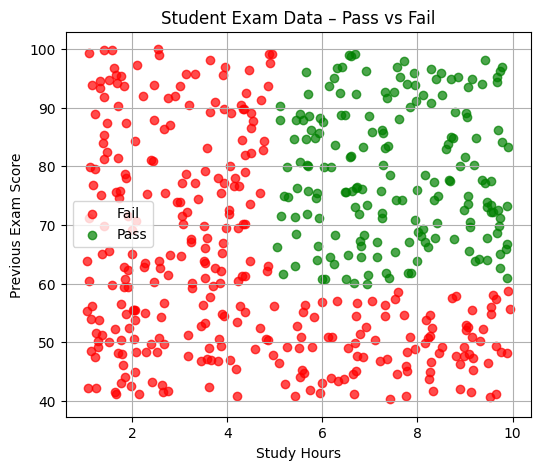

In [3]:

# Visualização inicial: scatter plot das duas variáveis de entrada
#  colunas: 'Study Hours', 'Previous Exam Score', 'Pass/Fail'

if not set(['Study Hours', 'Previous Exam Score', 'Pass/Fail']).issubset(df.columns):
    print("Atenção: os nomes das colunas podem ser diferentes no CSV baixado.")
    print("Colunas disponíveis:", df.columns.tolist())
else:
    plt.figure(figsize=(6,5))
    for label, cor, nome in [(0, 'red', 'Fail'), (1, 'green', 'Pass')]:
        subset = df[df['Pass/Fail'] == label]
        plt.scatter(subset['Study Hours'], subset['Previous Exam Score'],
                    c=cor, label=nome, alpha=0.7)
    plt.xlabel('Study Hours')
    plt.ylabel('Previous Exam Score')
    plt.title('Student Exam Data – Pass vs Fail')
    plt.legend()
    plt.grid(True)
    plt.show()


In [4]:

# Preparação dos dados para o modelo
# X = [Study Hours, Previous Exam Score]
# y = Pass/Fail (0 ou 1)

if not set(['Study Hours', 'Previous Exam Score', 'Pass/Fail']).issubset(df.columns):
    raise ValueError("As colunas esperadas não estão presentes no DataFrame. Verifique os nomes das colunas no CSV.")

X = df[['Study Hours', 'Previous Exam Score']].values.astype(np.float32)
y = df['Pass/Fail'].values.astype(np.int64)

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1234, stratify=y
)

print("Formato X_train:", X_train.shape)
print("Formato X_test:", X_test.shape)

# Normalização (min-max) com base no conjunto de treino
X_min = X_train.min(axis=0, keepdims=True)
X_max = X_train.max(axis=0, keepdims=True)
X_train_norm = (X_train - X_min) / (X_max - X_min)
X_test_norm  = (X_test  - X_min) / (X_max - X_min)

print("Após normalização:")
print("min treino:", X_train_norm.min(axis=0))
print("max treino:", X_train_norm.max(axis=0))


Formato X_train: (350, 2)
Formato X_test: (150, 2)
Após normalização:
min treino: [0. 0.]
max treino: [1. 1.]


In [5]:

# Convertendo para tensores PyTorch

X_train_tensor = torch.from_numpy(X_train_norm)
X_test_tensor  = torch.from_numpy(X_test_norm)
y_train_tensor = torch.from_numpy(y_train)
y_test_tensor  = torch.from_numpy(y_test)

print("X_train_tensor:", X_train_tensor.shape)
print("y_train_tensor:", y_train_tensor.shape)


X_train_tensor: torch.Size([350, 2])
y_train_tensor: torch.Size([350])


In [6]:

# Definição do modelo de Regressão Logística (Softmax)
# 2 entradas (Study Hours, Previous Exam Score)
# 2 saídas (classe 0 = Fail, classe 1 = Pass)

model = nn.Linear(2, 2)
print(model)


Linear(in_features=2, out_features=2, bias=True)


In [7]:

# Função de custo e otimizador
criterion = nn.CrossEntropyLoss()
lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=lr)


In [8]:

# Laço de treinamento

nb_epoch = 5000

losses_train = []
losses_test = []
acc_train_list = []
acc_test_list = []

for i in range(nb_epoch):
    # forward - predição
    output_train = model(X_train_tensor)
    output_test  = model(X_test_tensor)

    # cálculo da perda (loss) usando CrossEntropyLoss
    loss_train = criterion(output_train, y_train_tensor)
    loss_test  = criterion(output_test,  y_test_tensor)

    # backward + otimização
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    # guardando losses
    losses_train.append(loss_train.item())
    losses_test.append(loss_test.item())

    # cálculo da acurácia (treino)
    probs_train = torch.softmax(output_train, dim=1)
    _, class_train_max = torch.max(probs_train, dim=1)
    acc_train = (class_train_max == y_train_tensor).float().mean().item()
    acc_train_list.append(acc_train)

    # acurácia (teste)
    probs_test = torch.softmax(output_test, dim=1)
    _, class_test_max = torch.max(probs_test, dim=1)
    acc_test = (class_test_max == y_test_tensor).float().mean().item()
    acc_test_list.append(acc_test)

    # imprimir de tempos em tempos
    if (i+1) % 500 == 0:
        print(f"Epoch [{i+1}/{nb_epoch}] - Loss train: {loss_train.item():.4f} - Loss test: {loss_test.item():.4f} - Acc train: {acc_train:.3f} - Acc test: {acc_test:.3f}")

print("Loss final de treino:", losses_train[-1])
print("Loss final de teste :", losses_test[-1])


Epoch [500/5000] - Loss train: 0.3966 - Loss test: 0.3874 - Acc train: 0.860 - Acc test: 0.887
Epoch [1000/5000] - Loss train: 0.3381 - Loss test: 0.3248 - Acc train: 0.857 - Acc test: 0.907
Epoch [1500/5000] - Loss train: 0.3141 - Loss test: 0.2999 - Acc train: 0.857 - Acc test: 0.900
Epoch [2000/5000] - Loss train: 0.3012 - Loss test: 0.2871 - Acc train: 0.860 - Acc test: 0.893
Epoch [2500/5000] - Loss train: 0.2932 - Loss test: 0.2796 - Acc train: 0.860 - Acc test: 0.887
Epoch [3000/5000] - Loss train: 0.2880 - Loss test: 0.2749 - Acc train: 0.860 - Acc test: 0.887
Epoch [3500/5000] - Loss train: 0.2843 - Loss test: 0.2717 - Acc train: 0.860 - Acc test: 0.887
Epoch [4000/5000] - Loss train: 0.2816 - Loss test: 0.2695 - Acc train: 0.857 - Acc test: 0.887
Epoch [4500/5000] - Loss train: 0.2796 - Loss test: 0.2680 - Acc train: 0.857 - Acc test: 0.887
Epoch [5000/5000] - Loss train: 0.2780 - Loss test: 0.2669 - Acc train: 0.857 - Acc test: 0.893
Loss final de treino: 0.2780468761920929


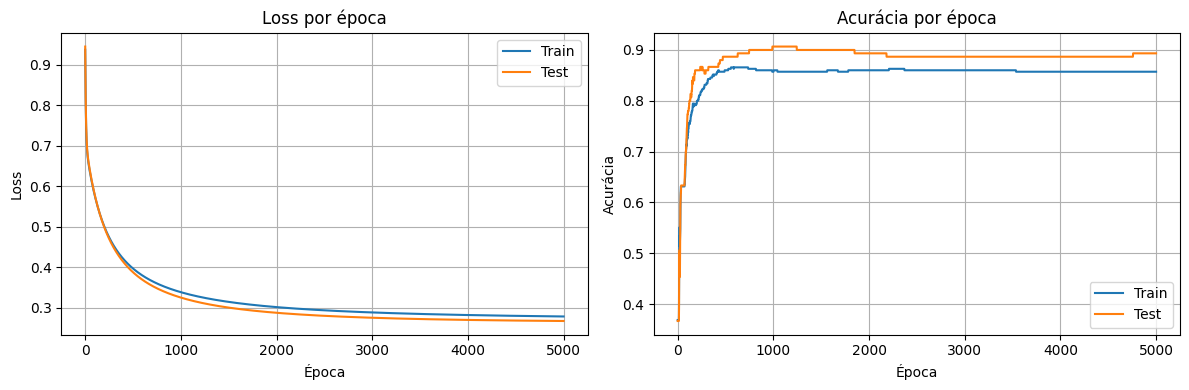

In [9]:

# Gráficos de evolução da loss e acurácia

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].plot(losses_train, label='Train')
ax[0].plot(losses_test, label='Test')
ax[0].set_title('Loss por época')
ax[0].set_xlabel('Época')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(acc_train_list, label='Train')
ax[1].plot(acc_test_list, label='Test')
ax[1].set_title('Acurácia por época')
ax[1].set_xlabel('Época')
ax[1].set_ylabel('Acurácia')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [10]:

# Matriz de confusão no conjunto de teste

y_test_pred = class_test_max.detach().cpu().numpy()
cm = confusion_matrix(y_test, y_test_pred)
print("Matriz de confusão (teste):")
print(cm)


Matriz de confusão (teste):
[[89  6]
 [10 45]]
